In [1]:
# импортируем нужные библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api



# Построение модели c 2 предикторами

In [18]:
# Выгрузим датасет
df = sns.load_dataset("titanic")

# Оставим нужные
df0 = df[['survived', 'pclass', 'sex','age']]

# Вывед
print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


Надо потсроить модель на основе двух факторов, но важно заметить, что pclass имеет 3 градации и, чтобы анализировать влияние кадого из классов более детально надо представить  этот столбец бинарно (через дамми-переменные)

In [19]:
# Создаем дамми-переменные для pclass
df = pd.get_dummies(data=df0, columns=['pclass'], drop_first=True)
print(df)

     survived     sex   age  pclass_2  pclass_3
0           0    male  22.0     False      True
1           1  female  38.0     False     False
2           1  female  26.0     False      True
3           1  female  35.0     False     False
4           0    male  35.0     False      True
..        ...     ...   ...       ...       ...
886         0    male  27.0      True     False
887         1  female  19.0     False     False
888         0  female   NaN     False      True
889         1    male  26.0     False     False
890         0    male  32.0     False      True

[891 rows x 5 columns]


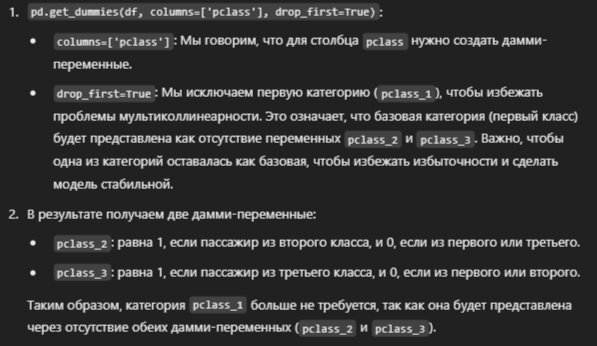

Теперь построим саму модель, которая отразит и влияние взаимодействия факторов и влияние каждого в отдельности

In [20]:
model = smf.glm('survived ~ sex + pclass_2 + pclass_3 + sex:pclass_2 + sex:pclass_3',
                data=df,
                family=statsmodels.api.families.Binomial()).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      885
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -399.05
Date:                Thu, 06 Feb 2025   Deviance:                       798.10
Time:                        17:46:50   Pearson chi2:                     891.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3534
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Интерпретация результатов

Разберемся по порядку. Сначала проинтерпретируем, что такое intercept

По скольку среди остальных коэфицентов по полу предствлена только градация male => в intercept ушла градация female. По  аналогии и первый класс. Значит в intercept информация о женщинах в первом классе

## **Intercept**

Теперь поймем как высчитывался коэфциент при intercept

In [21]:
# построим таблицу сопряженности
con_table = pd.crosstab(index=df0['survived'], columns=[df0['sex'], df0['pclass']] )
print(con_table)


sex      female         male         
pclass        1   2   3    1   2    3
survived                             
0             3   6  72   77  91  300
1            91  70  72   45  17   47


In [22]:
#посчитаем логарифм шансов выжить у женщин (положительный исход) в первом классе (это и есть  intercept)
l_odds = np.log(91/3)
print(l_odds)




3.41224721784874


 ## **Другие коэфиценты**

In [23]:
model = smf.glm('survived ~ sex + pclass_2 + pclass_3 + sex:pclass_2 + sex:pclass_3', data=df, family=statsmodels.api.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      885
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -399.05
Date:                Thu, 06 Feb 2025   Deviance:                       798.10
Time:                        17:46:51   Pearson chi2:                     891.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3534
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Важно понимать, что у нас фиксировано в интесепте - девушка в первом классе и  мы смотрим на то, какую цену мы заплтатим за изменение какой либо градации

In [24]:
# построим таблицу сопряженности
con_table = pd.crosstab(index=df0['survived'], columns=[df0['sex'], df0['pclass']] )
print(con_table)

sex      female         male         
pclass        1   2   3    1   2    3
survived                             
0             3   6  72   77  91  300
1            91  70  72   45  17   47


Коэфицент при sex_male - логарифм отношения шансов  выжить для мужчин в первом классе деленное на отношение шаносов выжить для женщин в первом классе

sex[T.male] =  log(male_class_1_odds / female_class_1_odds)




In [25]:
male_class_1_odds= 45/77
female_class_1_odds = 91/3

sex_male =  np.log(male_class_1_odds / female_class_1_odds)
# это и есть этот коэфицент
print(sex_male)



-3.9493901499321042


Можно это проинтерпртировать, как цену перехода с одной градациии на дргую так как

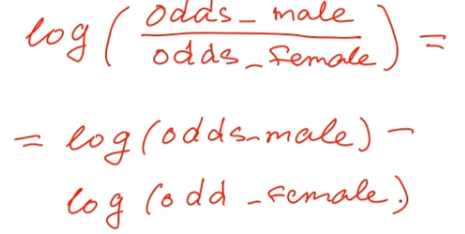

Таким же образом проинтерпртируем другие коэфиценты

p_class_second - логарифм шансов выжить у женщин во втором классе деленых на шансы выжить у женщин во втором классе. Ну и соответсвенно также это цена перехода с 1 на 2 класс если ты девушка

In [26]:
#проинтерпртируем коэфицент при p_class_second
female_class_2_odds= 70/6
female_class_1_odds = 91/3

pclass_2 =  np.log(female_class_2_odds / female_class_1_odds)
# это и есть этот коэфицент
print(pclass_2)

-0.9555114450274363


Заметим, что этот коэфицента статистически значимо не отличается от 0

pclass_3 по аналогии

In [27]:
#проинтерпртируем коэфицент при p_class_3
female_class_3_odds= 72/72
female_class_1_odds = 91/3

pclass_3 =  np.log(female_class_3_odds / female_class_1_odds)
# это и есть этот коэфицент
print(pclass_3)

-3.41224721784874


Теперь обратимся к коэфицентам о взаимодействии факторов

## Коэфиценты при взаимодействии факторов

Для начала заметим, что если для перового класса посчитать шансы выжить у мужчин деленые на шансы выжить у женщин, то получим число намного меньше 1, т к

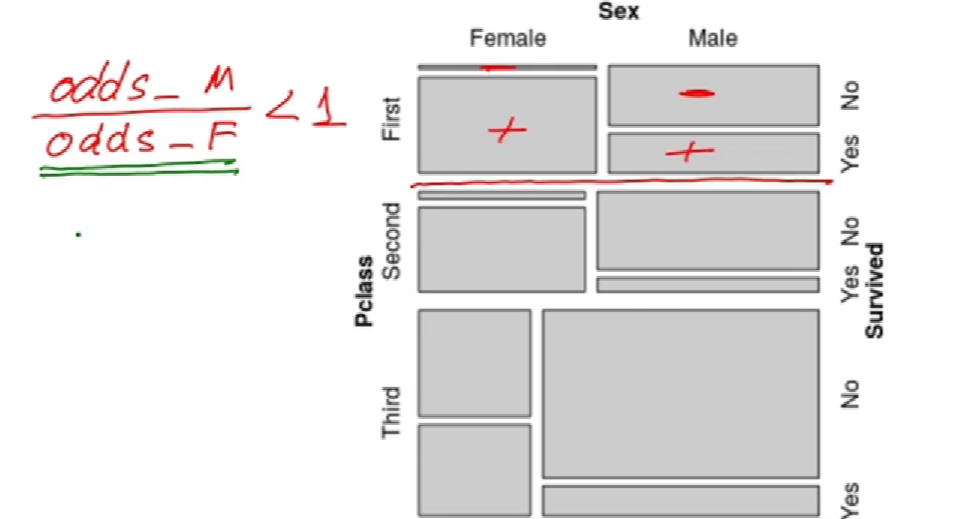

Если мы рассчитаем это значение для второго, класса получится примерно то же самое

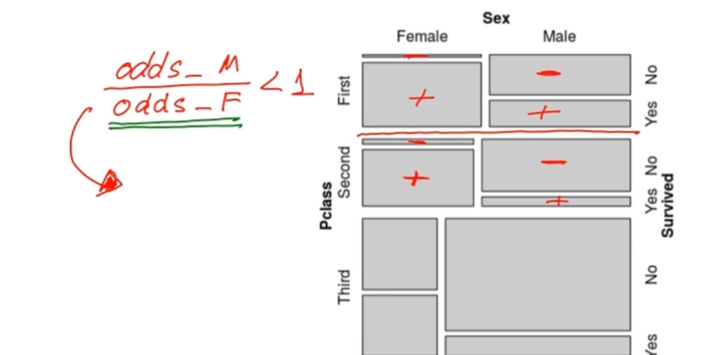

Но если рассчитаем такое отношение для 3 класса, то получим тоже число меньше 1, но не на много, т к

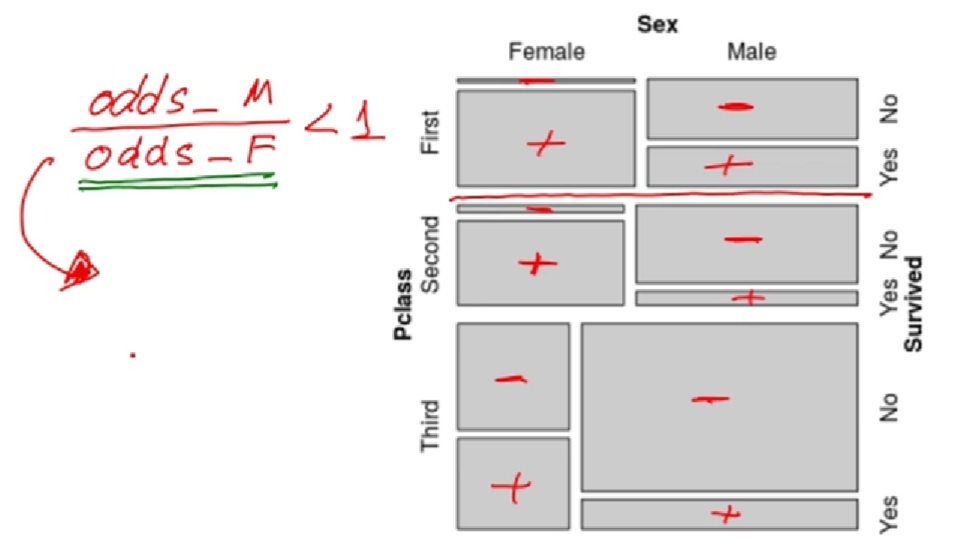

Заметим, что шансы выжить у женщин в 3 классе уже не настолько превосходят шансы выжить у мужчин в 3 классе

⏬

**Взаимосвязь между полом пассажира и тем выживет он или нет проявляется по разному в зависимости от класса**




 *Как рассчитываются эти самые коэфциценты взаимодействия факторов?*

Сначала разберемся с sex[T.male]:pclass_2[T.True]

Для начала рассчитаем отношение шансов выжить у мужчин во втором классе ( также по табл. сопряденности)

In [28]:
#рассчитаем отношение шансов выжить у мужчин во втором классе ( также по табл. сопряденности)
male_class_2_odds= 17/91
#рассчитаем отношение шансов выжить у женщин во втором классе
female_class_2_odds= 70/6
#посчитаем отношение шансов
print(male_class_2_odds/female_class_2_odds)
# теперь тоже самое для первого класса , т е для нашего интерсептного уровня
male_class_1 = 45/77
female_class_1_odds =  91/3
print(male_class_1/female_class_1_odds)


0.016012558869701727
0.01926644783787641


Заметим, что отношение шансов и в первом и во втором классе у мужчин и женшин примерно одинкаковое. Кстати, оно не является статистически значимым именно поэтому

In [29]:
sex_male__pclass_2 = np.log(male_class_2_odds/female_class_2_odds) - np.log(male_class_1/female_class_1_odds)
print(sex_male__pclass_2)
#заметим, что это и есть значение того коэфицента

-0.1849917853498333


Теперь проделаем это с взаимодействием фактора пола и 3 класса

In [30]:
#рассчитаем отношение шансов выжить у мужчин во втором классе ( также по табл. сопряденности)
male_class_3_odds= 47/300
#рассчитаем отношение шансов выжить у женщин во втором классе
female_class_3_odds= 72/72
#посчитаем отношение шансов
print(male_class_3_odds/female_class_3_odds)
# теперь тоже самое для первого класса , т е для нашего интерсептного уровня
male_class_1 = 45/77
female_class_1_odds =  91/3
print(male_class_1/female_class_1_odds)


0.15666666666666668
0.01926644783787641


Заметим, что уже теперь шансы для женщин  выжить в 3 классе  уже не настолько превосходят шансы мужчин выжить в 3 классе =>  различия статистически значимы

In [31]:
sex_male__pclass_3 = np.log(male_class_3_odds/female_class_3_odds) - np.log(male_class_1/female_class_1_odds)
print(sex_male__pclass_3)


2.0957552769859618


То есть взаимосвязь между полом и выживаемостью статистически значима, в зависмости от того 1 или 3 класс

Иными словами взаимосвязь между полом и выживаемостью проявляется по разному в зависимости от первого или третьего класса

# Прогнозирование на основе модели

Уравнение модели
logit(p) = 3.4 - 3.9 * sex_male - 0.96 * pclass_2 - 3.4 * pclass_3 - 0.2 * sex_male * pclass_2 + 2 * sex_male*pclass_3





Пускай появляется новая строка в данных:
мужчина из 3 класса

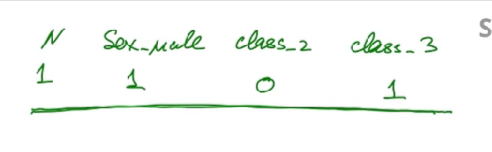

Тогда logit(p) = 3.4 - 3.9 - 0.96 * 0 - 3.4 * 1 - 0.2 * 0 + 2 * 1 = -1.9

ln(p/(1-p)) = -1.9

p = 0.13 (вероятность выжить)

# А стоило ли вообще включать эти предикторы и их взаимодейсвтие?

Для того чтобы оценить это, нужно обратиться к deviance.
Ведь чем меньше deviance, тем лучше модель

In [32]:
model_0 =  smf.glm('survived ~ 1', data=df, family=statsmodels.api.families.Binomial()).fit()
model_1 =  smf.glm('survived ~ sex ', data=df, family=statsmodels.api.families.Binomial()).fit()
model_2 =  smf.glm('survived ~ sex + pclass_2 + pclass_3', data=df, family=statsmodels.api.families.Binomial()).fit()
model_3 = smf.glm('survived ~ sex + pclass_2 + pclass_3 + sex:pclass_2 + sex:pclass_3', data=df, family=statsmodels.api.families.Binomial()).fit()
print(f"divence в модели без предикторов: {round(model_0.deviance)}")
print(f"divence в модели c предиктором sex : {round(model_1.deviance)}")
print(f"divence в модели с предикторами пола и класса: {round(model_2.deviance)}")
print(f"divence в модели с предикторами пола и класса и их взаимодействием: {round(model_3.deviance)}")

divence в модели без предикторов: 1187
divence в модели c предиктором sex : 918
divence в модели с предикторами пола и класса: 827
divence в модели с предикторами пола и класса и их взаимодействием: 798


Заметим, что действительно самый маленький deviance в модели с с предикторами пола и класса и их взаимодействием

# Постороение модели с 3 переменными

In [33]:
model_with_3_var = smf.glm('survived ~ sex + pclass_2 + pclass_3 + sex:pclass_2 + sex:pclass_3 + age', data=df, family=statsmodels.api.families.Binomial()).fit()
print(model_with_3_var.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      707
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -306.71
Date:                Thu, 06 Feb 2025   Deviance:                       613.43
Time:                        17:46:54   Pearson chi2:                     816.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3884
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Здесь уже в интреспте логарифм шансов выжить у девушек в первом классе  при условии, что их возраст равен 0

А значение при age показывает насколько изменится логарифм шансов базового уровня (интерсепта) при единичном изменении переменной age

Для того чтобы убедиться, стоило ли включать новую переменную посмотрим на devience

In [35]:
print(round(model_with_3_var.deviance))

613


Это действително меньше предылущих значений => добавление переменной улучашает модель
